In [19]:
import tensorflow as tf


@tf.keras.utils.register_keras_serializable()
class DQN(tf.keras.models.Model):
    def __init__(self, hidden_layers, output_layer):
        super(DQN, self).__init__()
        self.hidden_layers = hidden_layers
        self.output_layer = output_layer

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

    def get_config(self):
        config = {
            "hidden_layers": self.hidden_layers,
            "output_layer": self.output_layer,
        }
        return config

In [20]:
from collections import deque
import numpy as np


class ReplayBuffer(object):
    def __init__(self, memory_size) -> None:
        self.buffer = deque(maxlen=memory_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]

        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            states,
            actions,
            rewards.astype(np.float32),
            next_states,
            dones.astype(np.float32),
        )

In [21]:
import gymnasium as gym

env = gym.make("MountainCar-v0")
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

In [22]:
hidden_layers = [
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
]
output_layer = tf.keras.layers.Dense(action_size, activation="linear")

speed_weight = 1000
learning_rate = 0.005
epsilon_decay = 0.999
batch_size = 128
discount = 0.9
epsilon_min = 0.001
update_target_every = 40
epsilon = 1.0
num_episodes = 1000
buffer = ReplayBuffer(100000)

In [23]:
main_model = DQN(hidden_layers, output_layer)
target_model = DQN(hidden_layers, output_layer)
target_model.set_weights(main_model.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

In [24]:
def epsilon_greedy_policy(state, epsilon):
    if tf.random.uniform((1,)) < epsilon:
        return env.action_space.sample()
    return tf.argmax(main_model(state)[0]).numpy()


@tf.function
def train_step(states, actions, rewards, next_states, dones):
    next_qs = target_model(next_states)
    max_next_qs = tf.reduce_max(next_qs, axis=-1)
    target = rewards + (1.0 - dones) * discount * max_next_qs
    with tf.GradientTape() as tape:
        qs = main_model(states)
        action_masks = tf.one_hot(actions, action_size)
        qs = tf.reduce_sum(tf.multiply(qs, action_masks), axis=-1)
        loss = loss_fn(target, qs)
    grads = tape.gradient(loss, main_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, main_model.trainable_variables))
    return loss

In [25]:
episode_rewards = []
episode_losses = []
episode_epsilons = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward, done, truncated = 0, False, False
    losses = []
    while not done and not truncated:
        state_in = tf.expand_dims(state, axis=0)
        action = epsilon_greedy_policy(state_in, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        reward = reward + speed_weight * np.abs(next_state[1])
        episode_reward += reward
        buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(buffer) < batch_size:
            continue

        states, actions, rewards, next_states, dones = buffer.sample(batch_size)
        loss = train_step(states, actions, rewards, next_states, dones)
        losses.append(loss.numpy())

    if episode % update_target_every == 0:
        target_model.set_weights(main_model.get_weights())

    episode_rewards.append(episode_reward)
    episode_epsilons.append(epsilon)
    if len(losses) > 0:
        episode_losses.append(np.mean(losses))

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if episode % 10 == 0:
        print(
            f"Episode {episode} Reward: {episode_reward} Epsilon: {epsilon:.3f}",
            end=" ",
        )
        if len(losses) > 0:
            print(f"Loss: {np.mean(losses):.3f}")
        else:
            print()

Episode 0 Reward: 1731.1405885237036 Epsilon: 0.999 Loss: 91.932
Episode 10 Reward: 401.32764786339976 Epsilon: 0.989 Loss: 21.718
Episode 20 Reward: 564.2514276658119 Epsilon: 0.979 Loss: 22.349
Episode 30 Reward: 1211.4636054364382 Epsilon: 0.969 Loss: 20.373
Episode 40 Reward: 649.7988862654893 Epsilon: 0.960 Loss: 18.962
Episode 50 Reward: 2195.457094949961 Epsilon: 0.950 Loss: 19.110
Episode 60 Reward: 850.8035563991598 Epsilon: 0.941 Loss: 22.435
Episode 70 Reward: 455.7400219350029 Epsilon: 0.931 Loss: 16.507
Episode 80 Reward: 979.6051221247126 Epsilon: 0.922 Loss: 8.521
Episode 90 Reward: 1489.6144526763237 Epsilon: 0.913 Loss: 7.177
Episode 100 Reward: 969.510351435747 Epsilon: 0.904 Loss: 4.738
Episode 110 Reward: 1434.05636731477 Epsilon: 0.895 Loss: 3.481
Episode 120 Reward: 1146.6626334811735 Epsilon: 0.886 Loss: 2.465
Episode 130 Reward: 1236.201759341202 Epsilon: 0.877 Loss: 2.189
Episode 140 Reward: 1476.7081261641579 Epsilon: 0.868 Loss: 1.834
Episode 150 Reward: 964.

In [ ]:
import time

now = time.strftime("%Y-%m-%d_%H-%M-%S")

main_model.save(f"mountain/models/{now}_dqn_cartpole.keras")
hyperparams = {
    "num_episodes": num_episodes,
    "learning_rate": learning_rate,
    "epsilon": epsilon,
    "epsilon_min": epsilon_min,
    "epsilon_decay": epsilon_decay,
    "batch_size": batch_size,
    "discount": discount,
    "update_target_every": update_target_every,
    "speed_weight": speed_weight,
}
np.save(f"mountain/hyperparams/{now}_dqn_cartpole_hyperparams.npy", hyperparams)
metrics = {"episode_rewards": episode_rewards, "episode_losses": episode_losses}
np.save(f"mountain/metrics/{now}_dqn_cartpole_metrics.npy", metrics)

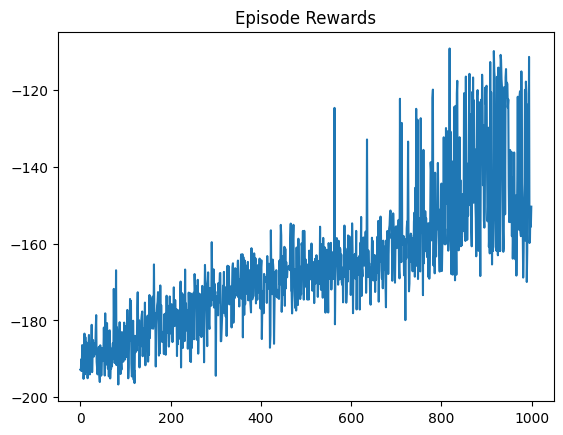

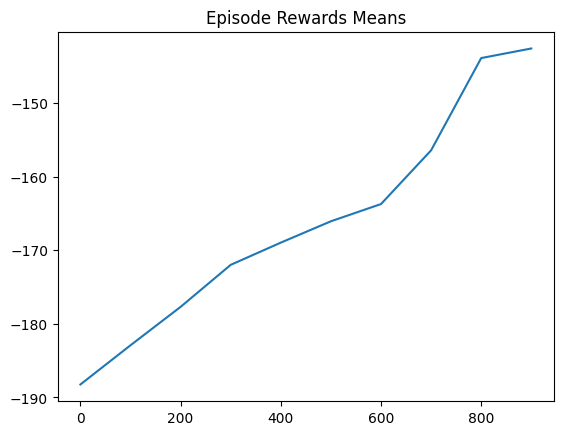

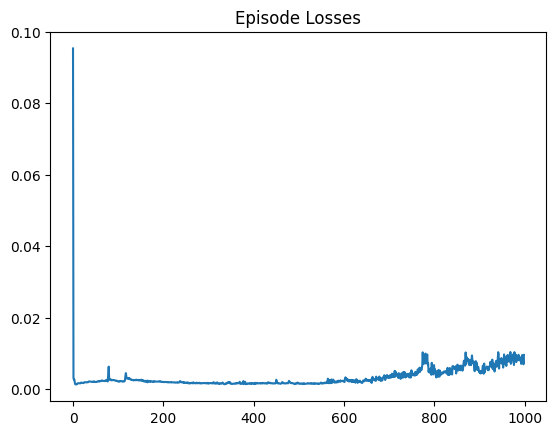

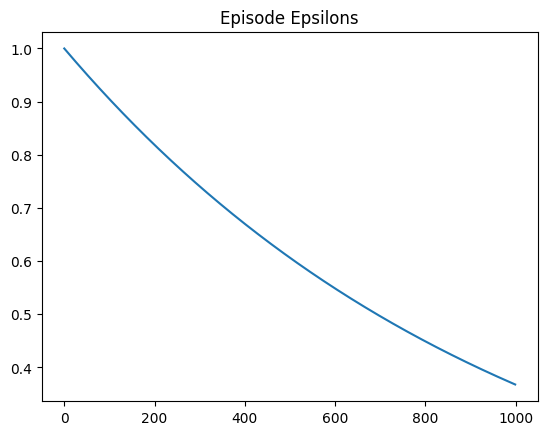

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.lineplot(data=episode_rewards)
plt.title("Episode Rewards")
plt.show()

episode_rewards_means = np.array(episode_rewards).reshape(-1, 100).mean(axis=1)
sns.lineplot(data=episode_rewards_means)
plt.title("Episode Rewards Means")
# Change x-axis scale
scale_x = 1e2
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(int(x * scale_x)))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

sns.lineplot(data=episode_losses)
plt.title("Episode Losses")
plt.show()

sns.lineplot(data=episode_epsilons)
plt.title("Episode Epsilons")
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import os

# Cargar el último modelo en la carpeta de modelos
models_path = "mountain/models"
last_model_path = sorted(os.listdir(models_path), reverse=True)[0]
model_path = os.path.join(models_path, last_model_path)
model = load_model(model_path)
model_path

/Users/jgonzalez@truora.com/miniconda3/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'dqn_4' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)


'mountain/models/2024-06-15_10-16-13_dqn_cartpole.keras'

In [ ]:
import pygame

test_env = gym.make("MountainCar-v0", render_mode="human")

evaluation_episodes = 10
for _ in range(evaluation_episodes):
    state, _ = test_env.reset()
    done, truncated = False, False
    total_reward = 0
    while not done and not truncated:
        state_in = tf.expand_dims(state, axis=0)
        action = tf.argmax(main_model(state_in)[0]).numpy()
        state, _, done, truncated, _ = test_env.step(action)

test_env.close()
pygame.quit()